In [1]:
import glob
import math
import os
import re

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# --- FUNCTION to preprocess .txt files for consistent delimiters


def preprocess_txt(file_path):
    data = []  # Initialize a list to store the processed data

    # Initialize a flag to determine if we are reading the header
    is_header = True

    # Read the file line by line and process the data
    with open(file_path) as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if is_header:
                # Split the first line into column names
                column_names = re.split(r"\s+", line)
                is_header = False
            else:
                # Split the other lines into data values
                values = re.split(r"\s+", line)
                data.append(values)

    # Create a DataFrame with the processed data and set column names
    df = pd.DataFrame(data, columns=column_names)
    # return
    return df


# --- FUNCTION to calculate pH from [H]


def calculate_pH(H_concentration):
    pH = -math.log10(H_concentration)
    return pH

In [9]:
# --- read in profile data
# profile data have one file per timestep, so we must read each in separately and combine


# where results are stored
results_path = "/home/tykukla/SCEPTER-1.0/scepter_output"
# results_dir = "test_inert_spinup_act_cec_20_Sikora_spintuneup_field"
results_dir = "site_311_v0_field"
# results_dir = "spinup_run_name_spintuneup_field"
# results_dir = "basApp20_gbas_field_tpH7p0_tau1"
# results_dir = "bas_SEASONWORKING_gbas_field_tpH6p2_tau1"
# results_dir = "bas_SEASON-30yr_gbas_field_tpH6p2_tau30"
# results_dir = "bas_shell_testrun_Sik01_gbas_field_tau45"
flx_path, prof_path = os.path.join(results_path, results_dir, "flx"), os.path.join(
    results_path, results_dir, "prof"
)

# define file name pattern
fn_pref = ["prof_aq-0"]
fn_ext = ".txt"

# loop through variables
df = pd.DataFrame()  # initialize empty df to store dat
for var in fn_pref:
    # set pattern
    fn_pattern = f"{var}*{fn_ext}"
    # get list of filenames
    file_paths = glob.glob(f"{prof_path}/{fn_pattern}")
    file_paths_numsOnly = [
        path for path in file_paths if re.search(r"\d", path.split("/")[-1])
    ]
    # read in data and concatenate
    for file_path in file_paths_numsOnly:
        dfi = preprocess_txt(file_path)
        # apply pd.to_numeric to all columns using the "map" method
        dfi = dfi.map(pd.to_numeric)
        # add var
        dfi["var"] = var.replace("-0", "")  # removes -0 suffix when saving var
        # combine
        df = pd.concat([df, dfi], ignore_index=True)


# sort by time and depth
df = df.sort_values(by=["var", "time", "z"])
df

,z,ca,k,mg,na,no3,ph,time,var
90,0.008333,0.000986,9.861465e-21,9.724626e-21,9.876860e-21,0.000007,8.507660,0.083334,prof_aq
91,0.025000,0.000996,9.909987e-21,9.822324e-21,9.910452e-21,0.000008,8.509541,0.083334,prof_aq
92,0.041667,0.001002,9.936829e-21,9.875149e-21,9.937139e-21,0.000008,8.509464,0.083334,prof_aq
93,0.058333,0.001006,9.955685e-21,9.912509e-21,9.956904e-21,0.000008,8.508935,0.083334,prof_aq
94,0.075000,0.001009,9.970841e-21,9.942671e-21,9.972517e-21,0.000008,8.508354,0.083334,prof_aq
...,...,...,...,...,...,...,...,...,...
415,0.425000,0.000975,9.949228e-21,9.711590e-21,9.975200e-21,0.000203,6.408485,10000.000001,prof_aq
416,0.441667,0.000975,9.949228e-21,9.711590e-21,9.975200e-21,0.000203,6.408485,10000.000001,prof_aq
417,0.458333,0.000975,9.949228e-21,9.711590e-21,9.975200e-21,0.000203,6.408485,10000.000001,prof_aq
418,0.475000,0.000975,9.949228e-21,9.711590e-21,9.975200e-21,0.000203,6.408485,10000.000001,prof_aq


In [10]:
# df['ph'] = df['h'].apply(lambda x: calculate_pH(x))
# df['exch_ac'] = df['h'] / (df['ca'] + df['k'] + df['mg'] + df['na'] + df['no3'] + df['h'])
# plt.plot(df['time'])

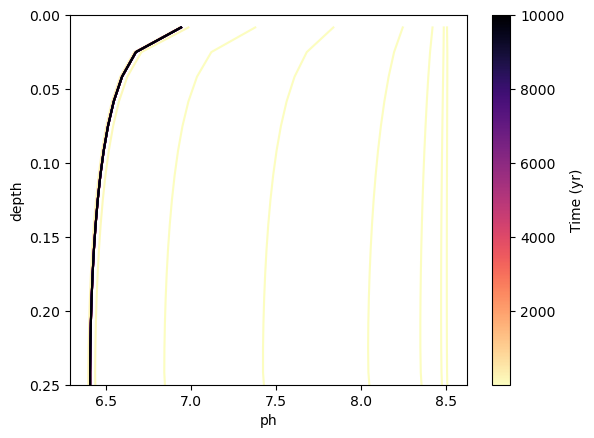

In [11]:
# --- pH panel PL0T
# plot decisions
ymin, ymax = 0, 0.25  # [m] depth range for plot
set_time_bounds = False
tmin, tmax = 0.0, 1.0
# var to plot
pcolumn = "ph"
vfile = "prof_aq"

# --- plot depth profile of calcite through time
if set_time_bounds:
    dfx = df[(df["var"] == vfile) & (df["time"] <= tmax) & (df["time"] > tmin)]
else:
    dfx = df[df["var"] == vfile]
# Group the DataFrame by the 'time' column
grouped = dfx.groupby("time")

# Create a colormap
cmap = plt.get_cmap("magma")  # Get the colormap
cmap = cmap.reversed()  # flip colormap
# -- no log normalization
norm = plt.Normalize(
    dfx["time"].min(), dfx["time"].max()
)  # Normalize time values for colormap
# -- log normalization WIP
# log_time = np.log(df['time'])
# norm = plt.Normalize(log_time.min(), log_time.max())  # Normalize time values for colormap

# Create a plot for each time step
for time, group in grouped:
    color = cmap(norm(time))  # Map time to color using Viridis colormap
    # plt.plot(-math.log10(group[pcolumn]), group['z'], color=color, label=None)
    plt.plot(group[pcolumn], group["z"], color=color, label=None)
    plt.ylim(ymin, ymax)
    # plt.xlim(5, 9)
    # plt.plot(group['gt'], group['z'], color=color, linestyle='dashed', label=None)

# Add labels and a legend
plt.xlabel(pcolumn)
plt.ylabel("depth")

# Create a colorbar based on the Viridis colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array for the colorbar data
cbar = plt.colorbar(sm, label="Time (yr)", ax=plt.gca())

# flip y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

In [2]:
# dfx['time'].unique()
# list(np.linspace(0.1,5.5,19))
alist = [(1.4, 1.4)]
len(alist)

1